# Creates plots for multiple steps

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

0

In [2]:
dataset = np.load('../compressed_2/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [3]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

# Extract a quake

In [4]:
#Get a single quake
quake = dataset[100]
quake = quake.reshape((1, *quake.shape))
quake.shape

(1, 60, 15)

In [5]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [6]:
past_history = 15
future_target = 5
STEP = 1

x_train_multi, y_train_multi = multivariate_data(quake, past_history,
                                                 future_target, STEP)

hist = quake[0, :15]

print(x_train_multi.shape, y_train_multi.shape, hist.shape)

(40, 15, 15) (40, 5, 15) (15, 15)


# Load the model

In [9]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(75))

multi_step_model.load_weights("trained_models/LSTM3_multi.h5")

multi_step_model.compile(optimizer='adam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 64)            20480     
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                2475      
Total params: 43,691
Trainable params: 43,691
Non-trainable params: 0
_________________________________________________________________


In [10]:
y_pred = multi_step_model.predict(x_train_multi)
y_pred = y_pred.reshape((y_pred.shape[0], 5, -1))
y_train_multi = y_train_multi.reshape((y_pred.shape[0], 5, -1))
y_pred.shape, y_train_multi.shape

((40, 5, 15), (40, 5, 15))

In [11]:
def accumulate(y):
    avg_pred = np.zeros((y.shape[0] + y.shape[1] - 1, 15))
    for i, pred in enumerate(y):
        avg_pred[i:i+5] += pred
    for i in range(len(avg_pred)):
        denom = min(5, i + 1, len(avg_pred) - i + 1)
        avg_pred[i] = avg_pred[i]/denom
        
    return avg_pred

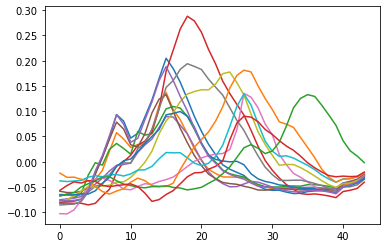

In [12]:
plt.plot(accumulate(y_pred))

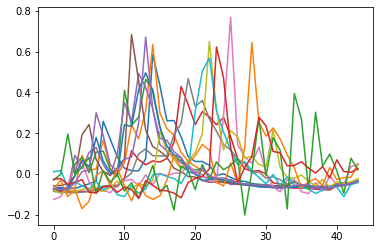

In [13]:
plt.plot(accumulate(y_train_multi))

In [14]:
import sys
import numpy as np
import json

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from math import radians, cos, sin, asin, sqrt

STATION_COORDS = {
    "CI.WVP2.": (35.94939, -117.81769),
    "CI.WRV2.": (36.00774, -117.8904),
    "CI.WRC2.": (35.9479, -117.65038),
    "CI.WNM.": (35.8422, -117.90616),
    "CI.WMF.": (36.11758, -117.85486),
    "CI.WCS2.": (36.02521, -117.76526),
    "CI.WBM.": (35.60839, -117.89049),
    "CI.TOW2.": (35.80856, -117.76488),
    "CI.SRT.": (35.69235, -117.75051),
    "CI.SLA.": (35.89095, -117.28332),
    "CI.MPM.": (36.05799 ,-117.48901),
    "CI.LRL.": (35.47954, -117.68212),
    "CI.DTP.": (35.26742, -117.84581),
    "CI.CCC.": (35.52495, -117.36453),
    "CI.JRC2.": (35.98249, -117.80885)
}


def CalcDistance(epicenter, station):
    """
    Calculates the distance between two gps points
    Source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    parameters
    ----------
    epicenter: tuple
    tuple of (lat, long) value for the epicenter of your earthquake
    
    station: tuple
    tuple of (lat, long) value for the location of your station
    
    Returns
    -------
    Distance: float 
    Distance between epicenter and station
    
    """
    
    lat1, lon1 = epicenter
    lat2, lon2 = station
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 3956
    return c * r


def create_time_steps(length):
    """
    Helper function for generating the time data for historical timeseries
    
    parameters
    ----------
    length: int
    Number of time steps in your historical time series
    
    Returns
    -------
    time_steps: List
    List containing the second-by-second time values of your history timeseries
    
    """
    
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps


def multi_step_plot(history, true_future, save_path, epicenter = None, prediction = None, scale = 1):
    """
    Plots the timeseries data for a given earthquake across the different stations
    based on the distance of each station from the epicenter of the quake,
    along with the predicted future time series for the quake
    
    parameters
    ----------
    history: numpy array, shape = (15, t_hist)
    The historical time series fed into the model
    
    true_future: numpy array, shape = (15, t_future)
    The true time series data of the given quake
    
    save_path: str
    Path under which to save the desired plot
    
    epicenter: tuple(float), default = None
    Latitude/Longitude point of the epicenter of the earthquake
    
    prediction: numpy array, shape = (15, t_future), default = None
    Time series of the predicted future progress of the quake
    
    scale: int
    Quantity by which to scale the plotted graphs
    
    Return
    ------
    None
    
    """
    
    distances = []
    plt.figure(figsize=(15, 10))
    num_in = create_time_steps(history.shape[1])
    num_out = true_future.shape[1]
    
    if epicenter is None:
        # Randomly assign epicenter to be CI.WRV2 if none given
        epicenter = (36.00774, -117.8904)
    
    mean = np.mean(history)
    std = np.std(history)
    
    for i in tqdm(range(len(STATION_COORDS))):
        station = list(STATION_COORDS.keys())[i]
        dist = CalcDistance(epicenter, STATION_COORDS[station])
        plt.plot(
            num_in,
            scale * (history[i] - mean)/std/2 + dist, 
            'gray', 
            linewidth = 1
        )
        
        plt.plot(
            np.arange(num_out),
            scale * (true_future[i] - mean)/std/2 + dist, 
            'b--',
            linewidth = 1
        )
        
        if prediction is not None:
            num_preds = prediction.shape[1]
            plt.plot(
                np.arange(num_preds),
                scale * (prediction[i] - mean)/std/2 + dist, 
                'r--',
                linewidth = 1
            )
            
        if i % 2 == 0:
            plt.text(num_in[0], dist, station)
        else:
            plt.text(num_in[5], dist, station)
    
    plt.ylabel("Distance from Epicenter (km)")
    plt.xlabel("Time (s)")
    

100%|██████████| 15/15 [00:00<00:00, 168.66it/s]

(35679, 15, 60)
(15, 15)
(15, 44)


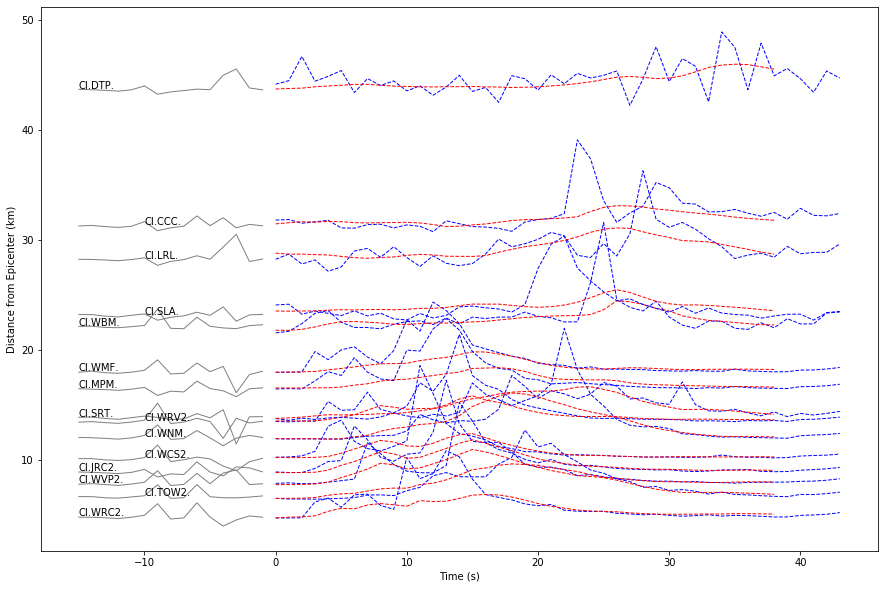

In [16]:
dataset = np.load('../compressed_2/full_data.npy')
metadata = None
with open('../compressed_2/event_metadata.json','r') as fd:
    metadata = json.load(fd)

# dataset = dataset.swapaxes(1, -1)
print(dataset.shape)

history = hist
true_future = accumulate(y_train_multi).swapaxes(0, 1)
print(history.shape)
print(true_future.shape)
epicenter = (metadata[0]['lat'], metadata[0]['lng'])
pred = accumulate(y_pred).swapaxes(0, 1)
multi_step_plot(history, true_future, './test/test_plot.png', epicenter, prediction = pred[:,:-5])